In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import display
pd.set_option('display.max_columns', None)
import geopandas as gpd
from shapely import Point, Polygon, MultiPolygon
import contextily as ctx

import mapclassify
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial import Voronoi
import osmnx as ox
ox.config(log_console=True, use_cache=True)
import pyproj
import math
from tqdm.notebook import tqdm
tqdm.pandas()
from collections import defaultdict
import h3

In [2]:
PATH_PROJECT = '..'
PATH_DATA = f'{PATH_PROJECT}/data'

In [3]:
df = pd.read_pickle(f'{PATH_DATA}/processed/df.pickle')

In [8]:
list_res = [4,5,6,7,8,9,10]

In [9]:
for res in list_res:
    df[f'h3_res_{res}'] = df.progress_apply(lambda p: h3.geo_to_h3(p.y, p.x, res), axis=1)

  0%|          | 0/26017 [00:00<?, ?it/s]

  0%|          | 0/26017 [00:00<?, ?it/s]

  0%|          | 0/26017 [00:00<?, ?it/s]

  0%|          | 0/26017 [00:00<?, ?it/s]

  0%|          | 0/26017 [00:00<?, ?it/s]

  0%|          | 0/26017 [00:00<?, ?it/s]

  0%|          | 0/26017 [00:00<?, ?it/s]

In [10]:
# доля нахождения ПВЗ трейн и тест в одних и тех же гексагонах
mask_train = df['split'] == 'train'
for res in list_res:
    set_h3_train = set(df.loc[mask_train, f'h3_res_{res}'])
    set_h3_test = set(df.loc[~mask_train, f'h3_res_{res}'])
    print(res, len(set_h3_train & set_h3_test) / len(set_h3_test))

4 0.6147342995169082
5 0.5186368477103301
6 0.46124031007751937
7 0.41379310344827586
8 0.23968503937007873
9 0.04427821680641853
10 0.004207735316156551


In [11]:
clms = ['id','h3_res_4', 'h3_res_5', 'h3_res_6', 'h3_res_7', 'h3_res_8', 'h3_res_9', 'h3_res_10',]
df[clms].to_pickle(f'{PATH_DATA}/processed/h3.pickle')

поищем ПВЗ из теста, которые расположены далеко от ПВЗ из трейна

In [12]:
res = 6
set_h3_train = set(df.loc[mask_train, f'h3_res_{res}'])
set_h3_test = set(df.loc[~mask_train, f'h3_res_{res}'])

set_h3_test_isolated = set_h3_test - set_h3_train
df['isolated'] = df[f'h3_res_{res}'].isin(set_h3_test_isolated)

In [13]:
df.query('isolated')['region'].value_counts()

Московская область                          275
Краснодарский край                          180
Ростовская область                          116
Республика Крым                             115
Свердловская область                         97
                                           ... 
Алматы                                        2
Ереван                                        1
Вайоцдзорская область                         1
город республиканского значения Байконур      1
Гехаркуникская область                        1
Name: region, Length: 116, dtype: int64

In [14]:
df.query('isolated')['locality'].value_counts()

Томск                      14
Смоленск                   12
Гагарин                    11
Шахты                      11
Троицк                     11
                           ..
село Перегребное            1
рабочий посёлок Вохтога     1
село Тээли                  1
поселок Научный Городок     1
деревня Терпилицы           1
Name: locality, Length: 2165, dtype: int64

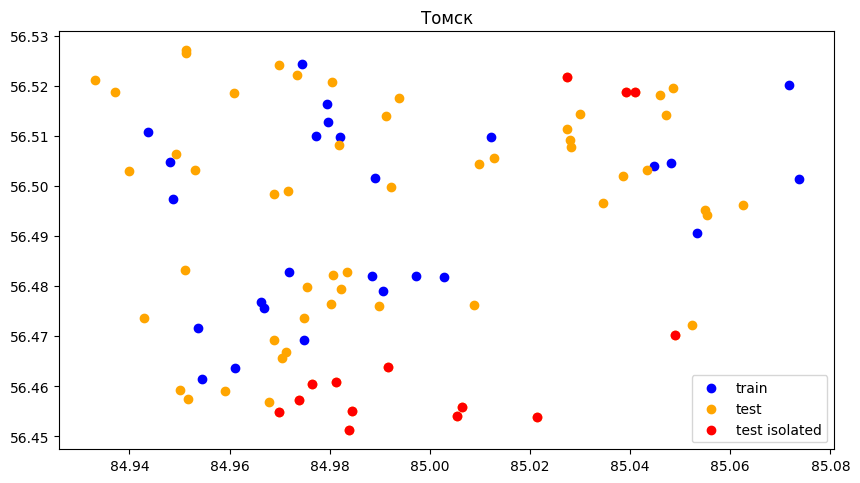

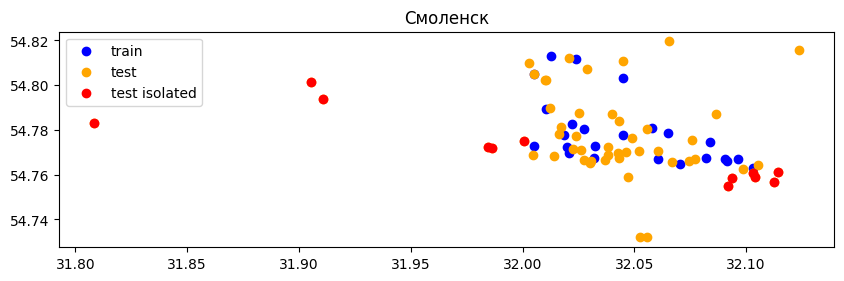

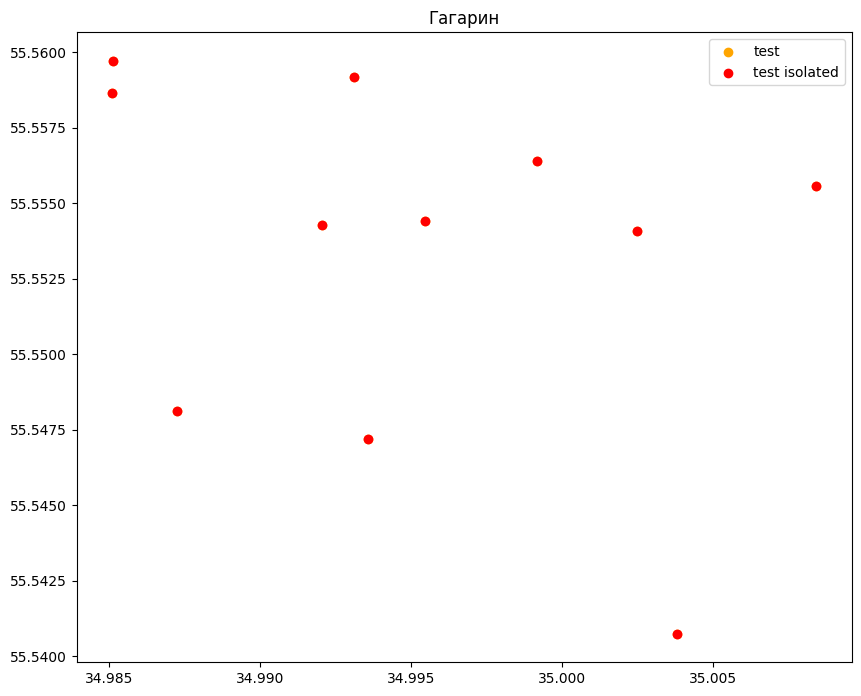

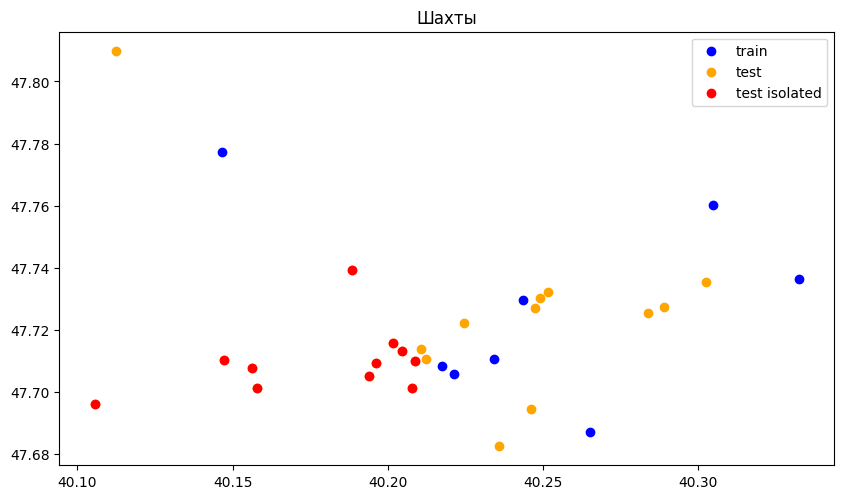

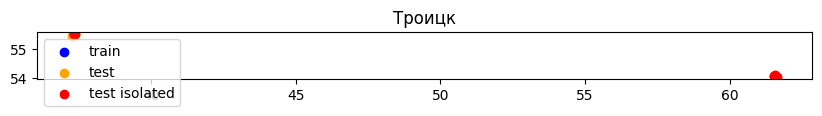

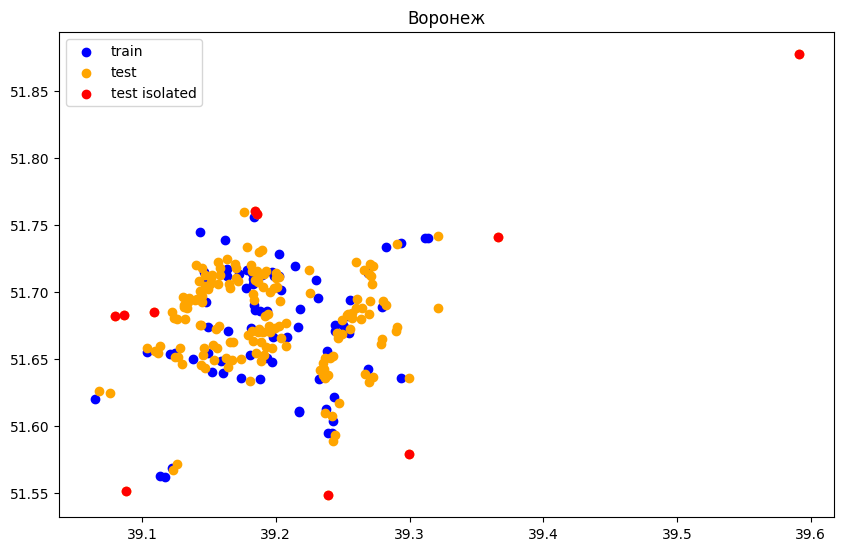

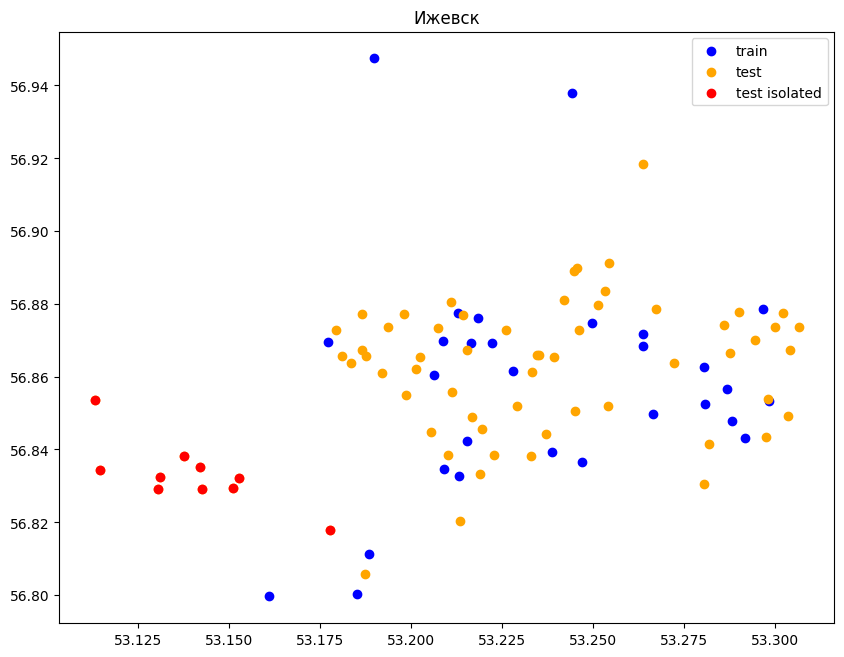

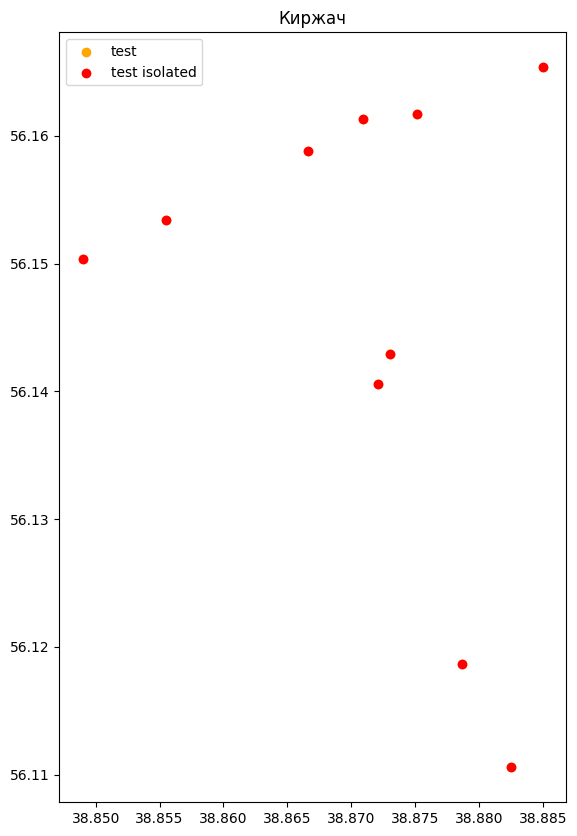

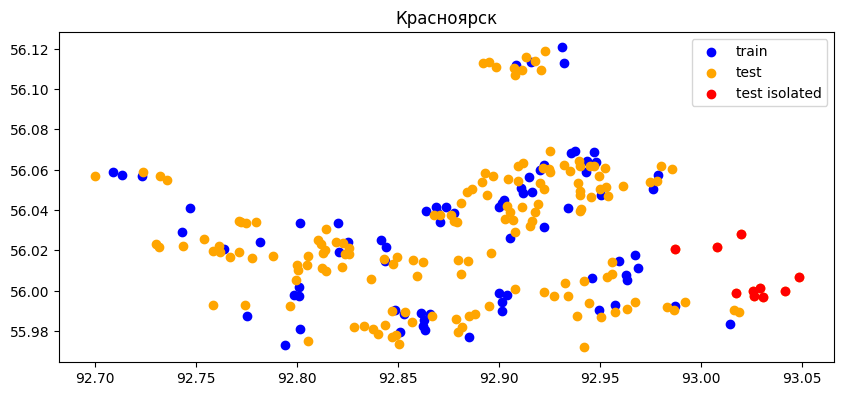

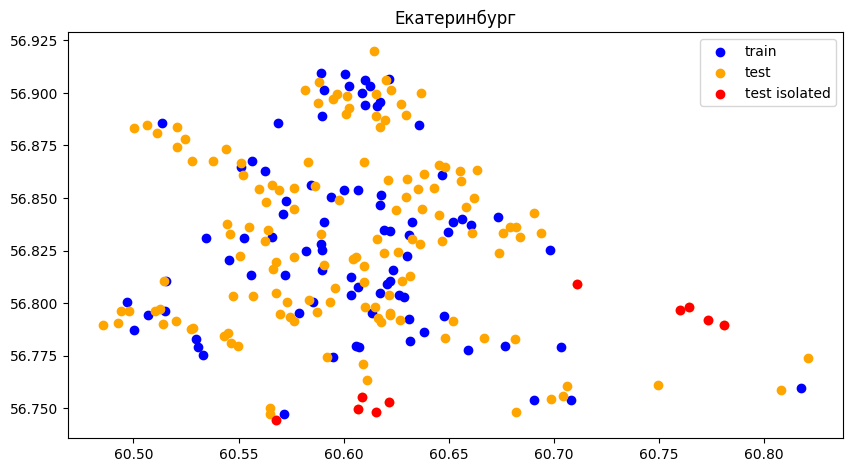

In [15]:
list_locality = df.query('isolated')['locality'].value_counts().index.tolist()

for locality in list_locality[:10]:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    mask = df['locality'] == locality
    mask_train = df['split'] == 'train'
    gpd.GeoSeries(df.loc[mask & mask_train, 'point']).plot(ax=ax, color='blue', label='train')
    gpd.GeoSeries(df.loc[mask & ~mask_train, 'point']).plot(ax=ax, color='orange', label='test')
    gpd.GeoSeries(df.loc[mask & ~mask_train & df['isolated'], 'point']).plot(ax=ax, color='red', label='test isolated')
    ax.set_title(locality)
    plt.legend()